In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets

from torchvision import transforms
from torch.utils.data import DataLoader
import cv2

import pandas as pd

import numpy as np
import matplotlib.pyplot as pyplot
import math
import matplotlib.pyplot as plt
from PIL import Image

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

from torchvision.utils import make_grid

import os

In [ ]:
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
# alexnet_model.eval()
model = alexnet_model

resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

def getAlexNet():
    return torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
    
def getResNet():
    return torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


**Prepare data.Use a 70:10:20 data split for training, validation and testing**

In [ ]:
isFile = os.path.exists("./tiny-imagenet-200") 
print("data downloaded ", isFile)
if isFile == False:
  !wget "http://cs231n.stanford.edu/tiny-imagenet-200.zip" -O "./tiny-imagenet-200.zip"
  !unzip -u "./tiny-imagenet-200.zip" -d "./"



Streaming output truncated to the last 5000 lines.
  inflating: ./tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9

**Preparing Dataset**

In [ ]:
import os
def prepare_dataset():
    
    dataroot = './tiny-imagenet-200/'
    trainset = datasets.ImageFolder(root=os.path.join(dataroot, 'train'))
    valset = datasets.ImageFolder(root=os.path.join(dataroot, 'val'))
    transformation = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    full_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(dataroot, 'train'),
        transform=transformation
    )
    
    #split data into 70:20:10
    data_size = len(full_dataset) 
     # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * data_size)
    test_size = int(0.2 * data_size)
    val_size = int(0.1 * data_size)
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size, val_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    val_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    return train_loader, test_loader, val_loader    


train_loader,test_loader, val_loader = prepare_dataset()
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"



**with cross-entropy loss**

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
#prepare dataset

train_Data = []
train_labels = []

batch_count = 3

train_x = None
train_y = None
test_x = None
test_y = None
val_x = None
val_y = None

for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        batchdata, batchtargets = data.to(device), target.to(device)
        train_Data.append(batchdata)
        train_labels.append(batchtargets)
        if batch_idx == batch_count:
            train_x = torch.cat(train_Data, dim=0).numpy()
            train_y = torch.cat(train_labels, dim=0).numpy()
            break

for batch_idx, (data, target) in enumerate(test_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        batchdata, batchtargets = data.to(device), target.to(device)
        train_Data.append(batchdata)
        train_labels.append(batchtargets)
        if batch_idx == batch_count:
            test_x = torch.cat(train_Data, dim=0).numpy()
            test_y = torch.cat(train_labels, dim=0).numpy()
            break

for batch_idx, (data, target) in enumerate(val_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        batchdata, batchtargets = data.to(device), target.to(device)
        train_Data.append(batchdata)
        train_labels.append(batchtargets)
        if batch_idx == batch_count:
            val_x = torch.cat(train_Data, dim=0).numpy()
            val_y = torch.cat(train_labels, dim=0).numpy()
            break

**One not-so-well-defined aspect of training CNNs is when to stop. Monitor your validation loss to decide on when to
stop. In other words, stop training when your validation loss starts to increase. If this is taking too many epochs, you can
stop at a pre-defined number of epochs that is dependent on your hardware.**

In [ ]:
def test(model, x, y):
    pass
    sample_size = min(100, x.shape[0]) #100
    batch_size = 10
    epoch = 15
    losses = []
    
    test_images = x[:sample_size]
    test_labels = y[:sample_size]
    
    permutation = np.random.permutation(sample_size)

    test_images_x = test_images[permutation]
    test_labels_y = test_labels[permutation]

    total_samples = len(test_images_x)
    
    # testing
    accuracy = 0
    loss = 0
    running_loss = 0.

    x = torch.from_numpy(np.array(test_images_x)).float()
    y = torch.from_numpy(test_labels_y) 
    

    model.eval()
    # Make predictions for this batch
    outputs = model(x)
    
    predictions = torch.argmax(outputs, dim = 1)
#     predictions = outputs
       
#     print(y.shape, outputs.shape, predictions.shape) 
    
    #calculate loss
    loss = loss_function(outputs, y)

    
    #calculate accuracy
    correct_predictions = ( predictions == y).sum().item()
    
#     print("correct", correct_predictions, "total", total_samples)
    accuracy =  correct_predictions / total_samples

    print ("Testing loss", loss.item() , "Accuracy", accuracy)
    
    return loss.detach().numpy() , accuracy 

#train 
def train(model, train_x, train_y, epoch):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    batch_size = 10
    
    running_loss = 0.
    last_loss = 0.
    losses = []
    testlosses = []
    
    #prepare train and test data
    total_samples = train_x.shape[0]
    sample_size = total_samples*7//8
    print ("total samples", total_samples, "sample size", sample_size)
    
    train_images = train_x[:sample_size]
    train_labels = train_y[:sample_size]
    test_images = train_x[sample_size:total_samples]
    test_labels = train_y[sample_size:total_samples]
#     print(train_images.shape, test_images.shape)
    # 15 epochs
    for epoch in range(epoch):
       
        model.train()        
        running_loss = 0.
        
        for i in range(sample_size//batch_size):
#         for batch_idx, (data, target) in enumerate(train_loader):    
            
#             data, target = data.to(device), target.to(device)
#             x = data
#             y = target
#             optimizer.zero_grad()
            
            start_i = i*batch_size
            end_i = (i+1) * batch_size 
            permutation = np.arange(start_i, end_i, 1)
            
            train_images_x = train_images[permutation]
            train_labels_y = train_labels[permutation]

            x = torch.from_numpy(np.array(train_images_x)).float()
            y = torch.from_numpy(train_labels_y)
            
#             x = x[:,None,:,:]
            
            # Make predictions for this batch
            outputs = model(x)
            
            predictions = torch.argmax(outputs, dim = 1)
            # training
            accuracy = 0
            loss = 0

            #calculate loss
            loss = loss_function(outputs, y)
            
            total_samples = len(train_images_x)
            #calculate accuracy
            correct_predictions = ( predictions == y).sum().item()
            accuracy =  correct_predictions / total_samples
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / batch_size
        losses.append(epoch_loss)
        
        print("")
        print('epoch {} Training loss: {}'.format(epoch + 1, epoch_loss))
        
        testloss, testaccuracy = test(model, test_images, test_labels)
        testlosses.append( testloss )
        
    xpoints = np.array(range(len(losses) ))
    plt.plot(xpoints, losses, label="training loss" )
    plt.plot(xpoints, testlosses, label="test loss" )
    plt.legend(loc="upper right")
    plt.show()
        
    return losses

def start_training(model ,  epoch = 15):
    sample_size = 1000 #1000
    batch_size = 100 #100
   
    
    train_images = train_x[:sample_size]
    train_labels = train_y[:sample_size]
    
    test_images = test_x[:sample_size]
    test_labels = test_y[:sample_size]
    
    losses = train(model, train_images, train_labels, epoch)
    return losses

**(a) Compute the error on the training and test data sets. Plot the training and test errors as a function of epochs (at the end of
training). (1)**

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


total samples 200 sample size 175

epoch 1 Training loss: 11.74190068244934
Testing loss 6.897913932800293 Accuracy 0.0

epoch 2 Training loss: 11.704831075668334
Testing loss 6.875189781188965 Accuracy 0.0

epoch 3 Training loss: 11.590157270431519
Testing loss 6.806080341339111 Accuracy 0.0

epoch 4 Training loss: 11.98658266067505
Testing loss 6.647469997406006 Accuracy 0.0

epoch 5 Training loss: 11.123979997634887
Testing loss 7.220193862915039 Accuracy 0.0

epoch 6 Training loss: 12.438608169555664
Testing loss 7.01546573638916 Accuracy 0.0

epoch 7 Training loss: 15.856572198867799
Testing loss 102.36566162109375 Accuracy 0.0

epoch 8 Training loss: 39.1338770866394
Testing loss 8.087196350097656 Accuracy 0.0

epoch 9 Training loss: nan
Testing loss nan Accuracy 0.0

epoch 10 Training loss: nan
Testing loss nan Accuracy 0.0


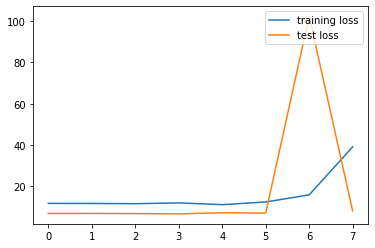

[11.74190068244934, 11.704831075668334, 11.590157270431519, 11.98658266067505, 11.123979997634887, 12.438608169555664, 15.856572198867799, 39.1338770866394, nan, nan]


In [ ]:
model = getAlexNet()
losses = train(model, train_x, train_y,10)
print(losses)

In [ ]:
def start_testing(model):
    pass
    sample_size = 100 #100
    batch_size = 10
    epoch = 15
    losses = []
    
    test_images = test_x[:sample_size]
    test_labels = test_y[:sample_size]
    
    permutation = np.random.permutation(sample_size)

#     permutation += epoch * (sample_size//batch_size)

    test_images_x = test_images[permutation]
    test_labels_y = test_labels[permutation]
    
    loss , accuracy  = test(model, test_images_x, test_labels_y)
    return loss , accuracy

start_testing(model)


Testing loss nan Accuracy 0.0


(array(nan, dtype=float32), 0.0)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


total samples 200 sample size 175

epoch 1 Training loss: 11.738822793960571
Testing loss 6.901417255401611 Accuracy 0.0

epoch 2 Training loss: 11.701551055908203
Testing loss 6.878513813018799 Accuracy 0.0

epoch 3 Training loss: 11.573022079467773
Testing loss 6.785928249359131 Accuracy 0.0

epoch 4 Training loss: 12.165818977355958
Testing loss 6.683935165405273 Accuracy 0.0

epoch 5 Training loss: 11.434892559051514
Testing loss 6.255031585693359 Accuracy 0.0

epoch 6 Training loss: 11.860837125778199
Testing loss 6.37687873840332 Accuracy 0.04

epoch 7 Training loss: 18.71760869026184
Testing loss 6.521458148956299 Accuracy 0.0

epoch 8 Training loss: nan
Testing loss nan Accuracy 0.0

epoch 9 Training loss: nan
Testing loss nan Accuracy 0.0

epoch 10 Training loss: nan
Testing loss nan Accuracy 0.0


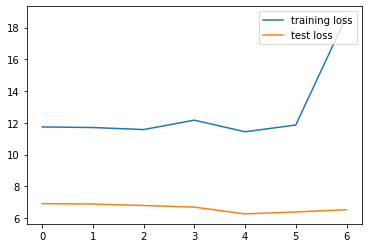

Training
loss nan
Testing loss nan Accuracy 0.0
Testing
accuracy 0.0 loss nan


In [ ]:
model = getAlexNet()
training_loss = start_training(model, epoch = 10)
#last epoch error
print ("Training")
print("loss", training_loss[-1] )

loss, accuracy = start_testing(model)
print ("Testing")
print("accuracy", accuracy, "loss" , loss)

**(b) Visualize the activation maps of the trained model. You can pick a couple of representative slices from the activation
volumes at a couple of convolution layers. (1)**

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


total samples 200 sample size 175

epoch 1 Training loss: 11.739618062973022
Testing loss 6.8978400230407715 Accuracy 0.0


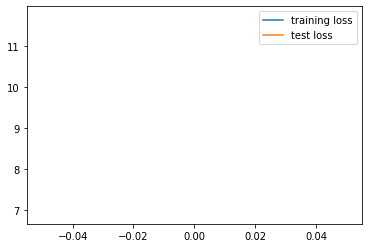

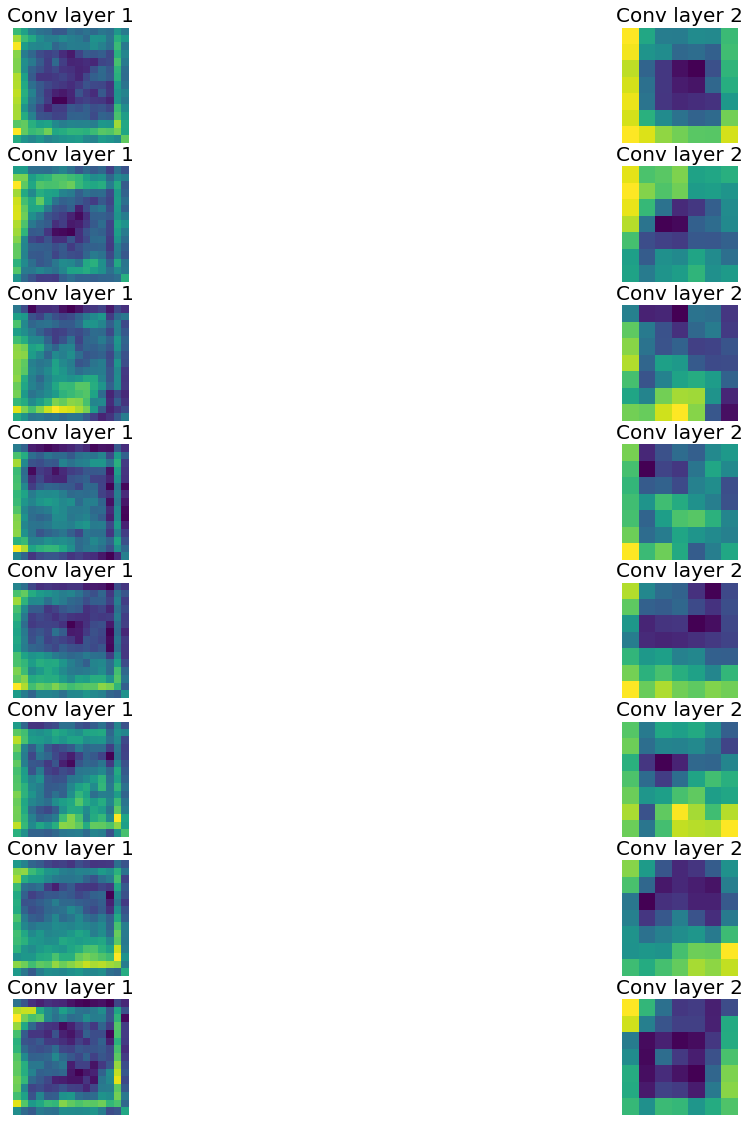

In [ ]:
outputimages_conv1 = []
outputimages_conv2 = []

def display_conv1(self, input, output):
    activation_map = output
    activation_map = activation_map.squeeze(0)
    gray_scale = torch.sum(activation_map,0)
    gray_scale = gray_scale / activation_map.shape[0]
    outputimages_conv1.append(gray_scale.data.cpu().numpy())

def display_conv2(self, input, output):
    activation_map = output
    activation_map = activation_map.squeeze(0)
    gray_scale = torch.sum(activation_map,0)
    gray_scale = gray_scale / activation_map.shape[0]
    outputimages_conv2.append(gray_scale.data.cpu().numpy())

#call training function after attaching hooks to get convolution output images
model = getAlexNet()

model.features[10].register_forward_hook(display_conv1)
model.features[12].register_forward_hook(display_conv2)

loss_vanila =start_training(model, epoch = 1)

#display conv layer1

fig = plt.figure(figsize=(20, 20))
cols = 2
images_tobe_displayed = min(8,len(outputimages_conv1))
rows = images_tobe_displayed // 2 * cols
 
for i in range(images_tobe_displayed):
    a = fig.add_subplot(rows, cols, i*2+1)
    a.axis('off')
    imgplot = plt.imshow(outputimages_conv1[i][0])
#     a.set_title(names[i].split('(')[0], fontsize=20)
    a.set_title("Conv layer 1", fontsize=20)
    
    a = fig.add_subplot(rows, cols, i*2+2)
    a.axis('off')
    imgplot = plt.imshow(outputimages_conv2[i][0])
#     a.set_title(names[i].split('(')[0], fontsize=20)
    a.set_title("Conv layer 2", fontsize=20)

    
outputimages_conv1 = []
outputimages_conv2 = []

**(c) Report the accuracy of your classifier. (1)**

In [ ]:
#TBD
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss, accuracy = start_testing(model)
print ("testing")
print("accuracy", accuracy)
print("loss" , loss)

Testing loss 6.893059730529785 Accuracy 0.03
testing
accuracy 0.03
loss 6.8930597


**(d) Use tSNE to visualize the bottleneck feature at the end of the first epoch and the last epoch. (1)**

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


(100, 3, 256, 256) (100,)
(10, 3, 256, 256) (10,)
unravelled vector (10, 100, 9216)
(1, 100, 9216) (1, 100)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No handles with labels found to put in legend.


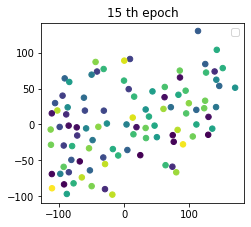

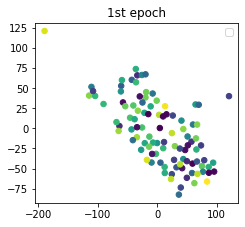

In [ ]:
# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.manifold import TSNE
import pandas as pd
from collections import defaultdict
# import seaborn as sns

    
def testing_for_tsne(model):

    sample_size = min(100, test_x.shape[0]) #100
    
    batch_size = 10
    epoch = 15
    losses = []
    
    test_images = test_x[:sample_size]
    test_labels = test_y[:sample_size]
    
    permutation = np.random.permutation(sample_size)

    test_images_x = test_images[permutation]
    test_images_y = test_labels[permutation]

    total_samples = len(test_images_x)
    
    # testing

    x = torch.from_numpy(np.array(test_images_x)).float()
    y = torch.from_numpy(test_images_y) 

#     x = x[:,None,:,:]

    model.eval()
    # Make predictions for this batch
    outputs = model(x)
    predictions = torch.argmax(outputs, dim = 1)    
    
    labels = test_images_y
    return np.array(labels)

def training_tsne(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    sample_size = min(100, train_x.shape[0]) #100
    batch_size = 10 #100
    epoch = 10
    
    train_images = train_x[:sample_size]
    train_labels = train_y[:sample_size]

    test_images = test_x[:sample_size//10]
    test_labels = test_y[:sample_size//10]

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)
      
    running_loss = 0.
    last_loss = 0.
    losses = []
    testlosses = []
    
    labels = []
    # 15 epochs
    for epoch in range(epoch):
       
        model.train()
        running_loss = 0.
        for i in range(sample_size//batch_size):
            
            optimizer.zero_grad()
            
            start_i = i*batch_size
            end_i = (i+1) * batch_size 
            permutation = np.arange(start_i, end_i, 1)
            
            # Shuffle the training data
#             permutation = np.random.permutation(batch_size)
            
#             permutation += i*batch_size
            
            
            train_images_x = train_images[permutation]
            train_labels_y = train_labels[permutation]
        
            # training
            accuracy = 0
            loss = 0

            x = torch.from_numpy(np.array(train_images_x)).float()
            y = torch.from_numpy(train_labels_y) 
            
#             x = x[:,None,:,:]
            
            # Make predictions for this batch
            outputs = model(x)

            #calculate loss
            loss = loss_function(outputs, y)
            running_loss += loss.item()

            loss.backward()

            # Adjust learning weights
            optimizer.step()

#             print('  batch {} loss: {}'.format(i + 1, loss))
        epoch_loss = running_loss / batch_size
        losses.append(epoch_loss)
        
#         print("")
#         print('epoch {} loss: {}'.format(epoch + 1, epoch_loss))
        
        test_labels_y = testing_for_tsne(model)
        
        labels.append(test_labels_y)
    
    return np.array(labels)

#create hook to collect unravelled output
unravelled_output_vector = []
def collect_unravelled_output(self, input, output):
    if self.training:
        # it's in train mode
        pass
    else:
        # it's in eval mode
        unravelled_output = output.detach().numpy()
#         print(unravelled_output.shape)
        unravelled_output_vector.append(unravelled_output)

# (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
#   (classifier): 
#create cnn
model = getAlexNet()
model.classifier[0].register_forward_hook(collect_unravelled_output)
#model.avgpool.register_forward_hook(collect_unravelled_output)
# cnn_05.conv2.register_forward_hook(display_conv2)

#list will get updated during testing and hook call back
global unravelled_output_vector
unravelled_output_vector = []
labels = training_tsne(model)
unravelled_output_vector = np.asarray(unravelled_output_vector)

# print (unravelled_output_vector.shape, labels.shape)
print ("unravelled vector", unravelled_output_vector.shape)

sne_input = np.array( [unravelled_output_vector[-1] ] )
label_ids = np.array([labels[-1] ] )

print (sne_input.shape, label_ids.shape)

# sne_input = np.array(unravelled_output_vector)
df = pd.DataFrame(np.row_stack(sne_input[0]))#, columns=sne_input.shape[1])

#prepare plot for 15th epoch
plt.figure(figsize = (8,4))
plt.subplots_adjust(top = 1.5)

tsne = TSNE(n_components = 2, perplexity = 10, random_state=0)
tsne_results = tsne.fit_transform(df)
tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
index = 0
plt.subplot(2,2,index+1)
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=label_ids, s=30)
plt.title('15 th epoch')
plt.legend(loc="upper right")


#prepare plot for first epoch
sne_input = np.array( [unravelled_output_vector[0] ] )
label_ids = np.array([labels[0] ] )

df = pd.DataFrame(np.row_stack(sne_input[0]))#, columns=sne_input.shape[1])

plt.figure(figsize = (8,4))
plt.subplots_adjust(top = 1.5)

tsne = TSNE(n_components = 2, perplexity = 10, random_state=0)
tsne_results = tsne.fit_transform(df)
tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
index = 0
plt.subplot(2,2,index+1)
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=label_ids, s=30)
plt.title('1st epoch')
plt.legend(loc="upper right")

![image.png](attachment:image.png)

**(e) Compare the performance of the two models in terms of the accuracy and training time (number of epochs) required for
the training loss to stabilize. Comment on which model you would pick for this task considering a trade-off between
performance and the number of parameters. (1)**

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training Alexnet
total samples 200 sample size 175

epoch 1 Training loss: 11.743025875091552
Testing loss 6.9000983238220215 Accuracy 0.0

epoch 2 Training loss: 11.705400371551514
Testing loss 6.875891208648682 Accuracy 0.0

epoch 3 Training loss: 11.578868341445922
Testing loss 6.781240940093994 Accuracy 0.0

epoch 4 Training loss: 12.194980144500732
Testing loss 6.713313579559326 Accuracy 0.0

epoch 5 Training loss: 11.314299058914184
Testing loss 6.825214862823486 Accuracy 0.0

epoch 6 Training loss: 12.647900056838989
Testing loss 6.629364013671875 Accuracy 0.04

epoch 7 Training loss: 11.50343370437622
Testing loss 6.577484130859375 Accuracy 0.0

epoch 8 Training loss: 10.816967678070068
Testing loss 6.287395000457764 Accuracy 0.0

epoch 9 Training loss: nan
Testing loss nan Accuracy 0.0

epoch 10 Training loss: nan
Testing loss nan Accuracy 0.0


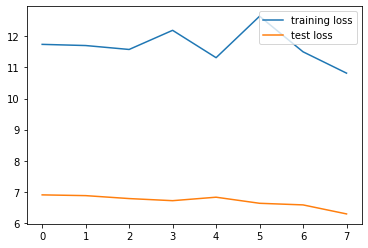

Testing loss nan Accuracy 0.0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training ResNet
total samples 200 sample size 175

epoch 1 Training loss: 11.827109909057617
Testing loss 17.249425888061523 Accuracy 0.0

epoch 2 Training loss: 10.412126350402833
Testing loss 567.7987060546875 Accuracy 0.0

epoch 3 Training loss: 12.775800275802613
Testing loss 2593.05908203125 Accuracy 0.12

epoch 4 Training loss: 15.276203823089599
Testing loss 1410.38671875 Accuracy 0.0

epoch 5 Training loss: 16.074120712280273
Testing loss 1044.0997314453125 Accuracy 0.08

epoch 6 Training loss: 15.441677618026734
Testing loss 460.5799255371094 Accuracy 0.04

epoch 7 Training loss: 14.565647745132447
Testing loss 313.6371154785156 Accuracy 0.0

epoch 8 Training loss: 13.405505037307739
Testing loss 240.8558349609375 Accuracy 0.0

epoch 9 Training loss: 11.86692705154419
Testing loss 183.09140014648438 Accuracy 0.0

epoch 10 Training loss: 10.695803117752074
Testing loss 165.62213134765625 Accuracy 0.0


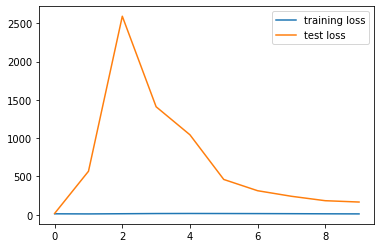

Testing loss 106.8921890258789 Accuracy 0.03


In [ ]:
#alexnet

model = getAlexNet()
print ("Training Alexnet")
losses = train(model, train_x, train_y, epoch=10 )
loss, accuracy = test(model, test_x, test_y)

#rnn
model = getResNet()
print ("Training ResNet")
losses = train(model, train_x, train_y, epoch=10 )
loss, accuracy = test(model, test_x, test_y)

**Q.2 a)**

**preparing data**

In [ ]:
isFile = os.path.exists("./data") 
print("data downloaded ", isFile)
if isFile == False:
  !wget "https://download.pytorch.org/tutorial/data.zip" -O "./data.zip"
  !unzip -u "./data.zip" -d "./"

data downloaded  False
--2022-05-04 19:55:51--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.51, 13.226.52.128, 13.226.52.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘./data.zip’

./data.zip          100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2022-05-04 19:55:51 (21.1 MB/s) - ‘./data.zip’ saved [2882130/2882130]

Archive:  ./data.zip
   creating: ./data/
  inflating: ./data/eng-fra.txt      
   creating: ./data/names/
  inflating: ./data/names/Arabic.txt  
  inflating: ./data/names/Chinese.txt  
  inflating: ./data/names/Czech.txt  
  inflating: ./data/names/Dutch.txt  
  inflating: ./data/names/English.txt  
  inflating: ./data/names/French.txt  
  inflating: ./data/names/German.txt  
  inflating: ./data/names/Greek.txt  
  inflating: ./data/names/I

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt']
Slusarski


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letterToTensor('A')
print ("input ", input)
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

input  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8462, -2.8306, -2.8123, -2.9293, -2.8067, -3.0238, -2.9784, -2.8799,
         -2.8359, -2.8827, -2.9146, -2.8497, -3.0207, -2.8751, -2.9132, -2.9623,
         -2.7794, -2.9293]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 16)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = OwYang
category = Russian / line = Zhdanovich
category = Dutch / line = Dael
category = Irish / line = O'Shea
category = Czech / line = Herodes
category = Italian / line = Nelli
category = Chinese / line = Tsang
category = Dutch / line = Buren
category = Arabic / line = Guirguis
category = Dutch / line = Meeuwissen


In [ ]:
criterion = nn.NLLLoss()

**Train RNN**

In [ ]:
learning_rate = 0.005 

def train_rnn(rnn, category_tensor, line_tensor):
    
    if isinstance(rnn, RNN) :
        hidden = rnn.initHidden()
    else:
        hidden = rnn.initHidden(line_tensor.size()[0])
        
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def rnn_start_training(rnn):
    start = time.time()

    n_iters = 100000
    print_every = 5000
    plot_every = 1000
    
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        
        output, loss = train_rnn(rnn, category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
        
    plt.figure()
    plt.plot(all_losses)

    return all_losses
            


5000 5% (0m 5s) 2.3144 Lokhtin / Scottish ✗ (Russian)
10000 10% (0m 11s) 1.4627 Slusarczyk / Polish ✓
15000 15% (0m 16s) 2.6305 Gottlieb / Dutch ✗ (German)
20000 20% (0m 21s) 1.7941 Vandroogenbroeck / Dutch ✓
25000 25% (0m 27s) 0.4147 Shimamura / Japanese ✓
30000 30% (0m 32s) 0.8179 Raghailligh / Irish ✓
35000 35% (0m 38s) 1.7325 Romijnsen / Scottish ✗ (Dutch)
40000 40% (0m 43s) 0.8597 Zong / Chinese ✓
45000 45% (0m 49s) 2.0228 Barros / Portuguese ✗ (Spanish)
50000 50% (0m 55s) 2.0591 Brown / Irish ✗ (Scottish)
55000 55% (1m 0s) 0.3184 Panoulias / Greek ✓
60000 60% (1m 6s) 0.2893 Alchevsky / Russian ✓
65000 65% (1m 12s) 1.1918 Ruadhain / Irish ✓
70000 70% (1m 18s) 0.2724 O'Neal / Irish ✓
75000 75% (1m 23s) 4.5760 Fabian / Irish ✗ (Polish)
80000 80% (1m 29s) 0.4630 Teunissen / Dutch ✓
85000 85% (1m 34s) 0.8020 Romeijnders / Dutch ✓
90000 90% (1m 40s) 1.5525 Johnstone / English ✗ (Scottish)
95000 95% (1m 45s) 0.2641 Diep / Vietnamese ✓
100000 100% (1m 51s) 0.8952 Pitterman / Czech ✓


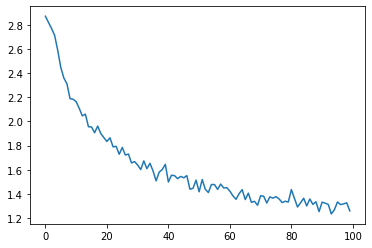

In [ ]:
all_losses = rnn_start_training(rnn)


**validate rnn**

In [ ]:
# Just return an output given a line
def evaluate(rnn, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def start_evaluate(rnn):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(rnn, line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    
    return confusion

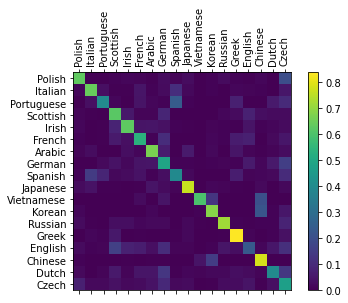

In [ ]:
confusion = start_evaluate(rnn)

 **(b) Replace the RNN in the previous question with a GRU and report the classification performance. GRU help can be found
here. (5)**

GRU Training
500 5% (0m 2s) 3.0739 Hutmacher / English ✗ (German)
1000 10% (0m 5s) 4.6977 Mar / Portuguese ✗ (Chinese)
1500 15% (0m 7s) 1.7076 Guillory / Dutch ✗ (French)
2000 20% (0m 10s) 0.1851 Tivoli / Italian ✓
2500 25% (0m 12s) 1.0136 Sun / Korean ✓
3000 30% (0m 15s) 5.9912 Pahlke / Russian ✗ (German)
3500 35% (0m 17s) 1.7818 Ponec / Dutch ✗ (Czech)
4000 40% (0m 20s) 0.3663 Schirovsky / Russian ✓
4500 45% (0m 22s) 0.5699 Stoep / Dutch ✓
5000 50% (0m 25s) 2.6282 Nairn / Irish ✗ (English)
5500 55% (0m 27s) 0.0126 Spini / Italian ✓
6000 60% (0m 30s) 0.0109 Warszawski / Polish ✓
6500 65% (0m 32s) 4.4311 Nielsen / Dutch ✗ (English)
7000 70% (0m 35s) 1.2742 Torres / Portuguese ✓
7500 75% (0m 37s) 0.4219 Penners / Dutch ✓
8000 80% (0m 40s) 0.3902 Bishara / Arabic ✓
8500 85% (0m 42s) 0.2112 Cvacek / Czech ✓
9000 90% (0m 44s) 0.1440 Sowka / Polish ✓
9500 95% (0m 47s) 0.4529 Pho / Vietnamese ✓
10000 100% (0m 49s) 2.3509 Travers / Spanish ✗ (French)


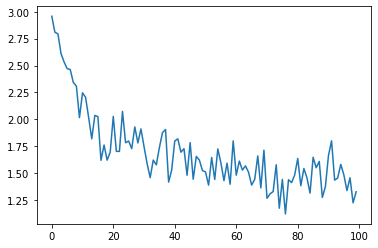

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.num_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, h):
#         print("forward intput ", x.shape,"hidden " , h.shape)
        hidden_state = self.initHidden(1)
        output, hidden_state = self.gru(x, hidden_state)
        output = self.fc(output[-1])
        return output, hidden
    
    def initHidden(self):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
        
    def initHidden(self, batch_size =1):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
    
n_layers = 2
gru = GRUNet(n_letters, n_hidden, n_categories,  n_layers = n_layers)
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
h0 = torch.randn(n_categories, 10, n_hidden  )

print("GRU Training")
criterion = nn.CrossEntropyLoss()
start = time.time()

n_iters = 10000
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []
    

current_loss = 0
for iter in  range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, hidden = gru(line_tensor, h0)
    loss = criterion(output, category_tensor)
    current_loss += loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
        


Confusion matrix GRU


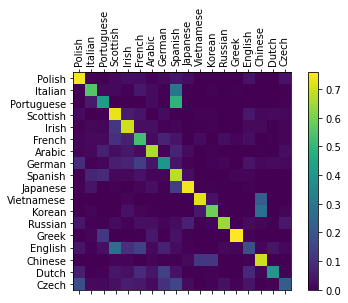

In [ ]:
def start_evaluate_gru_lstm(rnn):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
#         output = evaluate(rnn, line_tensor)
        output, hidden =  gru(line_tensor, h0)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    
    return confusion
print ( "Confusion matrix GRU")
confusion = start_evaluate_gru_lstm(gru)

**(c) Replace the GRU in the previous question with an LSTM and report the classification performance. LSTM help can be
found here. (5)**

LSTM training
500 5% (1m 6s) 2.5951 Giannakos / Arabic ✗ (Greek)
1000 10% (1m 10s) 0.3492 Chu / Chinese ✓
1500 15% (1m 13s) 0.8197 Noh / Korean ✓
2000 20% (1m 16s) 2.2359 Franco / Italian ✗ (Portuguese)
2500 25% (1m 18s) 2.6414 Oorschot / English ✗ (Dutch)
3000 30% (1m 21s) 1.9324 Hwang / Chinese ✗ (Korean)
3500 35% (1m 23s) 1.6880 Mcintosh / Arabic ✗ (Scottish)
4000 40% (1m 26s) 2.4055 Daviau / Irish ✗ (French)
4500 45% (1m 29s) 1.2877 Salcedo / Portuguese ✗ (Spanish)
5000 50% (1m 32s) 4.5028 Toset / German ✗ (Spanish)
5500 55% (1m 34s) 1.3161 Di antonio / Spanish ✗ (Italian)
6000 60% (1m 37s) 0.0274 Nakayama / Japanese ✓
6500 65% (1m 40s) 4.5402 Azzara / Arabic ✗ (Italian)
7000 70% (1m 42s) 6.1924 Salomon / French ✗ (Italian)
7500 75% (1m 45s) 0.0367 Lieu / Vietnamese ✓
8000 80% (1m 48s) 1.7826 Chaim / Korean ✗ (Chinese)
8500 85% (1m 51s) 0.7773 Cantu / Italian ✓
9000 90% (1m 53s) 0.6113 Nowell / English ✓
9500 95% (1m 56s) 1.5429 Allegro / Portuguese ✗ (Italian)
10000 100% (1m 59s) 

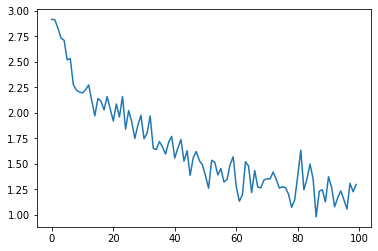

In [ ]:
device = "cpu"
class LSTMNet(nn.Module):
    def __init__(self,  input_size, hidden_size, output_size, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_size = input_size
        self.n_layers = n_layers
        
        self.num_layers = n_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, h):
        hidden_state = self.initHidden(1)
        output, hidden_state = self.lstm(x, hidden_state)
        output = self.fc(output[-1])
        
        return output, hidden_state
    
    def initHidden(self):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
        
    def initHidden(self, batch_size =1):
#          return torch.zeros(self.n_layers, 1, self.hidden_size)
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))
        return hidden
        
 #(n_letters, n_hidden, n_categories,  n_layers = n_layers)   
lstm = LSTMNet(n_letters, n_hidden, n_categories,  n_layers = n_layers)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

print( "LSTM training")
all_losses = []
current_loss = 0
for iter in  range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, hidden = lstm(line_tensor, h0)
    loss = criterion(output, category_tensor)
    current_loss += loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
   

Confusion matrix LSTM


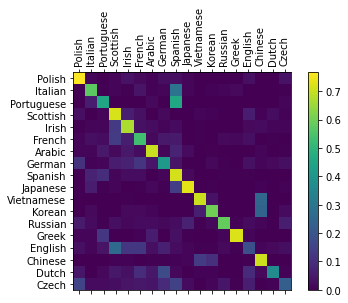

In [ ]:
print ("Confusion matrix LSTM")
confusion = start_evaluate_gru_lstm(lstm)